In [2]:
import numpy as np 
import pandas as pd 
import re
import torch
import seaborn as sns
import warnings
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [4]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from string import punctuation as pnc
from collections import Counter
from wordcloud import WordCloud

In [5]:
df = pd.read_csv('dataset/tweets.csv')
df.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,retweet_count,favorite_count,longitude,latitude,place_id,place_full_name,place_name,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,en,218,651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,en,2445,5308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,en,7834,27234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,en,916,2542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,en,859,2882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [6]:
df.isna().sum()

id                            0
handle                        0
text                          0
is_retweet                    0
original_author            5722
time                          0
in_reply_to_screen_name    6236
in_reply_to_status_id      6242
in_reply_to_user_id        6236
is_quote_status               0
lang                          0
retweet_count                 0
favorite_count                0
longitude                  6432
latitude                   6432
place_id                   6240
place_full_name            6240
place_name                 6240
place_type                 6240
place_country_code         6240
place_country              6240
place_contained_within     6240
place_attributes           6240
place_bounding_box         6240
source_url                    0
truncated                     0
entities                      0
extended_entities          5096
dtype: int64

In [7]:
''' taking only 3 features '''
df = df[['handle','text','is_retweet']]
df.head()

,handle,text,is_retweet
0,HillaryClinton,The question in this election: Who can put the...,False
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True
3,HillaryClinton,"If we stand together, there's nothing we can't...",False
4,HillaryClinton,Both candidates were asked about how they'd co...,False


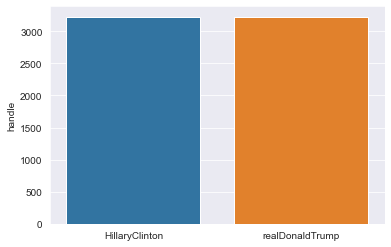

In [8]:
handle_label = df['handle'].value_counts()
sns.barplot(handle_label.index, handle_label);

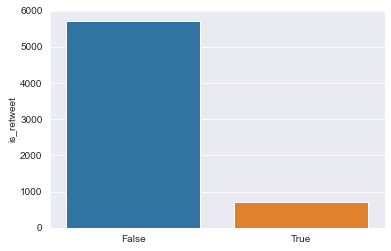

In [9]:
is_retweet_label = df.is_retweet.value_counts()
sns.barplot(is_retweet_label.index, is_retweet_label);

In [10]:
''' separating donald and hillary tweets '''
realDonaldTrump = df[df.handle == 'realDonaldTrump']
hillaryClinton = df[df.handle == 'HillaryClinton']
realDonaldTrump.head()

,handle,text,is_retweet
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False
8,realDonaldTrump,"Once again, we will have a government of, by a...",False
11,realDonaldTrump,"On National #VoterRegistrationDay, make sure y...",True
12,realDonaldTrump,Hillary Clinton's Campaign Continues To Make F...,False
13,realDonaldTrump,"'CNBC, Time magazine online polls say Donald T...",False


In [11]:
hillaryClinton.head()

,handle,text,is_retweet
0,HillaryClinton,The question in this election: Who can put the...,False
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True
3,HillaryClinton,"If we stand together, there's nothing we can't...",False
4,HillaryClinton,Both candidates were asked about how they'd co...,False


In [12]:
def get_word_cloud(df, c):
    cm = ' '
    s_word = set(STOPWORDS)
    
    for sent in df[c]:
        ''' converting sent into string '''
        sent = str(sent)
        ''' spiltting every sent from (" ") '''
        tokens = sent.split()
        
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        ''' joining all tokesn '''
        cm += " ".join(tokens)
    
    word_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=s_word,
                           min_font_size=10).generate(cm)
    
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(word_cloud) 
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    plt.show()

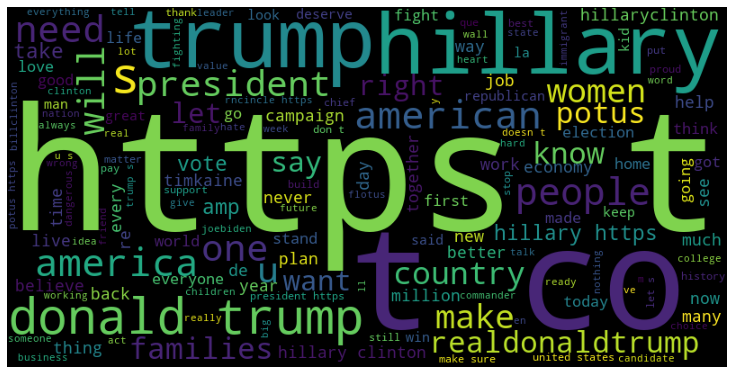

In [13]:
get_word_cloud(hillaryClinton,'text')

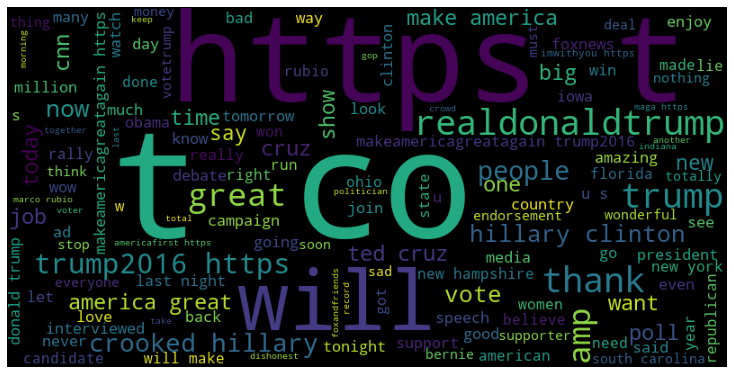

In [14]:
get_word_cloud(realDonaldTrump, 'text')

In [15]:
''' extracting words that start with (@) '''
def extract_words(df, c):
    words = []
    for t in df[c].tolist():
        t = [x for x in t.split() if x.startswith('@')]
        words += t
    print(words[:10])

In [16]:
extract_words(realDonaldTrump, 'text')

['@WashTimes.', '@GovernorSununu.', '@WSJ:', '@CNN', '@foxandfriends', '@CNN', '@TerryBranstad!', '@Mike_Pence!', '@TedCruz!', "@HillaryClinton's"]


In [17]:
extract_words(hillaryClinton, 'text')

['@HillaryClinton.', '@POTUS.', '@HillaryClinton', '@HillaryClinton', '@KatieMcGintyPA:', '@HillaryClinton', '@Wellesley', '@HillaryClinton', '@HardballChris', '@HillaryClinton']


In [18]:
''' extracting words that start with (#) '''
def extract_words_(df, c):
    words = []
    for t in df[c].tolist():
        t = [x for x in t.split() if x.startswith('#')]
        words += t
    print(words[:10])

In [19]:
extract_words_(realDonaldTrump, 'text')

['#VoterRegistrationDay,', '#MakeAmericaGreatAgain…', '#MAGA', '#ImWithYou', '#MAGA', '#MAGA', '#AmericaFirst', '#MAGA', '#ImWithYou…', '#TrumpWon']


In [20]:
extract_words_(hillaryClinton, 'text')

['#NationalVoterRegistrationDay', '#NationalVoterRegistrationDay.', '#LoveTrumpsHate', '#StrongerTogether', '#NationalVoterRegistrationDay', '#NationalVoterRegistrationDay', '#Debates2016?', '#NationalVoterRegistrationDay.', '#SheWon…', '#iRegistered…']


In [21]:
''' extracting words that start with (—) '''
def extract_words_(df, c):
    words = []
    for t in df[c].tolist():
        t = [x for x in t.split() if x.startswith('—')]
        words += t
    
    print(words[:10])

In [22]:
extract_words_(realDonaldTrump, 'text')

['—Donald']


In [23]:
extract_words_(hillaryClinton, 'text')

['—Trump,', '—Hillary', '—Hillary', '—Hillary', '—Hillary', '—Hillary', '—Hillary', '—Trump', '—@JoeBiden', '—@JoeBiden']


In [24]:
# tweets where Hillary mentioned herself
hillaryClinton['tweet_lower'] = hillaryClinton['text'].str.lower()
hillaryClinton[hillaryClinton['tweet_lower'].str.contains('hillary')]['text'].head()

2     Couldn't be more proud of @HillaryClinton. Her...
9     3) Has Trump offered a single proposal to redu...
19    "I love this country.\nI’m proud of this count...
21    "What we hear from my opponent is dangerously ...
23    "What kind of a person would want to root for ...
Name: text, dtype: object

In [25]:
# tweets where Trump mentioned himself
realDonaldTrump['tweet_lower'] = realDonaldTrump['text'].str.lower()
realDonaldTrump[realDonaldTrump['tweet_lower'].str.contains('trump')]['text'].head()

13    'CNBC, Time magazine online polls say Donald T...
49    Thank you! #TrumpWon #MAGA \nhttps://t.co/a5rr...
52    'True blue-collar billionaire Donald Trump sho...
53    The #1 trend on Twitter right now is #TrumpWon...
55    'How Trump won over a bar full of undecideds a...
Name: text, dtype: object

In [26]:
''' removing all tags (@, #, -) '''
def remove_tags(t):
    text = " ".join([x for x in t.split(" ") if not x.startswith("@")])
    text = " ".join([x for x in text.split(" ") if not x.startswith("#")])
    text = " ".join([x for x in text.split(" ") if not x.startswith("—")])
    return text

In [27]:
hillaryClinton['text_prepro'] = hillaryClinton['text'].str.replace('http\S+|www.\S+', '', case=False)
hillaryClinton['text_prepro'] = hillaryClinton['text_prepro'].str.replace('\n', '')
hillaryClinton['text_prepro'] = hillaryClinton['text_prepro'].map(remove_tags)

realDonaldTrump['text_prepro'] = realDonaldTrump['text'].str.replace('http\S+|www.\S+', '', case=False)
realDonaldTrump['text_prepro'] = realDonaldTrump['text_prepro'].str.replace('\n', '')
realDonaldTrump['text_prepro'] = realDonaldTrump['text_prepro'].map(remove_tags)

In [29]:
hillaryClinton.head()

,handle,text,is_retweet,tweet_lower,text_prepro
0,HillaryClinton,The question in this election: Who can put the...,False,the question in this election: who can put the...,The question in this election: Who can put the...
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,"last night, donald trump said not paying taxes...","Last night, Donald Trump said not paying taxes..."
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,couldn't be more proud of @hillaryclinton. her...,Couldn't be more proud of Her vision and comma...
3,HillaryClinton,"If we stand together, there's nothing we can't...",False,"if we stand together, there's nothing we can't...","If we stand together, there's nothing we can't..."
4,HillaryClinton,Both candidates were asked about how they'd co...,False,both candidates were asked about how they'd co...,Both candidates were asked about how they'd co...


In [31]:
realDonaldTrump.head()

,handle,text,is_retweet,tweet_lower,text_prepro
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False,join me for a 3pm rally - tomorrow at the mid-...,Join me for a 3pm rally - tomorrow at the Mid-...
8,realDonaldTrump,"Once again, we will have a government of, by a...",False,"once again, we will have a government of, by a...","Once again, we will have a government of, by a..."
11,realDonaldTrump,"On National #VoterRegistrationDay, make sure y...",True,"on national #voterregistrationday, make sure y...",On National make sure you're registered to vot...
12,realDonaldTrump,Hillary Clinton's Campaign Continues To Make F...,False,hillary clinton's campaign continues to make f...,Hillary Clinton's Campaign Continues To Make F...
13,realDonaldTrump,"'CNBC, Time magazine online polls say Donald T...",False,"'cnbc, time magazine online polls say donald t...","'CNBC, Time magazine online polls say Donald T..."
